# Inference

Imports, constants, and utils. We'll use the higher accuracy model I trained instead of the smaller one we used to get the code working.

In [1]:
from fastai.vision.all import *

DATA = Path("/home/rory/data")
MODEL = DATA / "nacti" / "2021-12-13-1830_cats6_err036"
TEST_ANNOS = DATA / "trailcam" / "annos.json"

def load_json(path):
    return json.load(open(path))

We load the weights of the trained model using a helper function from fastai.

In [2]:
inf = load_learner(MODEL)
cats = inf.dls.vocab

cats

['american black bear', 'california ground squirrel', 'cougar', 'empty', 'mule deer', 'vehicle']

I will now load in the annos that I hand-specified using a computer vision annotation tool. These tools are basically just image viewing tools that also let you draw and label rectangles on your images & output the details of those annotations to JSON or CSV. In notebook 02, I show you the CSV my annotation tool gave me via export, and I go through the steps I took to clean it up into the "flat" JSON format you see below.

In [3]:
test = load_json(TEST_ANNOS)

Let's take a look at one:

In [4]:
list(test.keys())[0]

'16372053860754'

In [5]:
list(test.values())[0]

{'path': '/home/rory/data/trailcam/1637205386_SYFW0754.jpg',
 'width': 1920,
 'height': 1440,
 'cat_ids': [0],
 'cats': ['person'],
 'bboxes': [[1384.6648454157782,
   611.1416709863745,
   182.3074360341152,
   391.18875888625587]]}

I'm going to throw away the keys to the test data b/c I don't need them, plus I'd rather have everything in a list format. The `L` class is actually fastai's improvement to the built-in `list` – it does everything `list` does (and stuff like map/filter/reduce) faster.

In [6]:
test = L(test.values())

Here's a little pattern I do in my python notebooks... I init an index to -1, then I keep on running the next cell to cycle through images one-by-one.

In [7]:
i=-1

0 /home/rory/data/trailcam/1637205386_SYFW0754.jpg


american black bear : 0.0
california ground squirrel : 0.0
cougar : 0.02
empty : 0.0
mule deer : 0.2
vehicle : 0.78


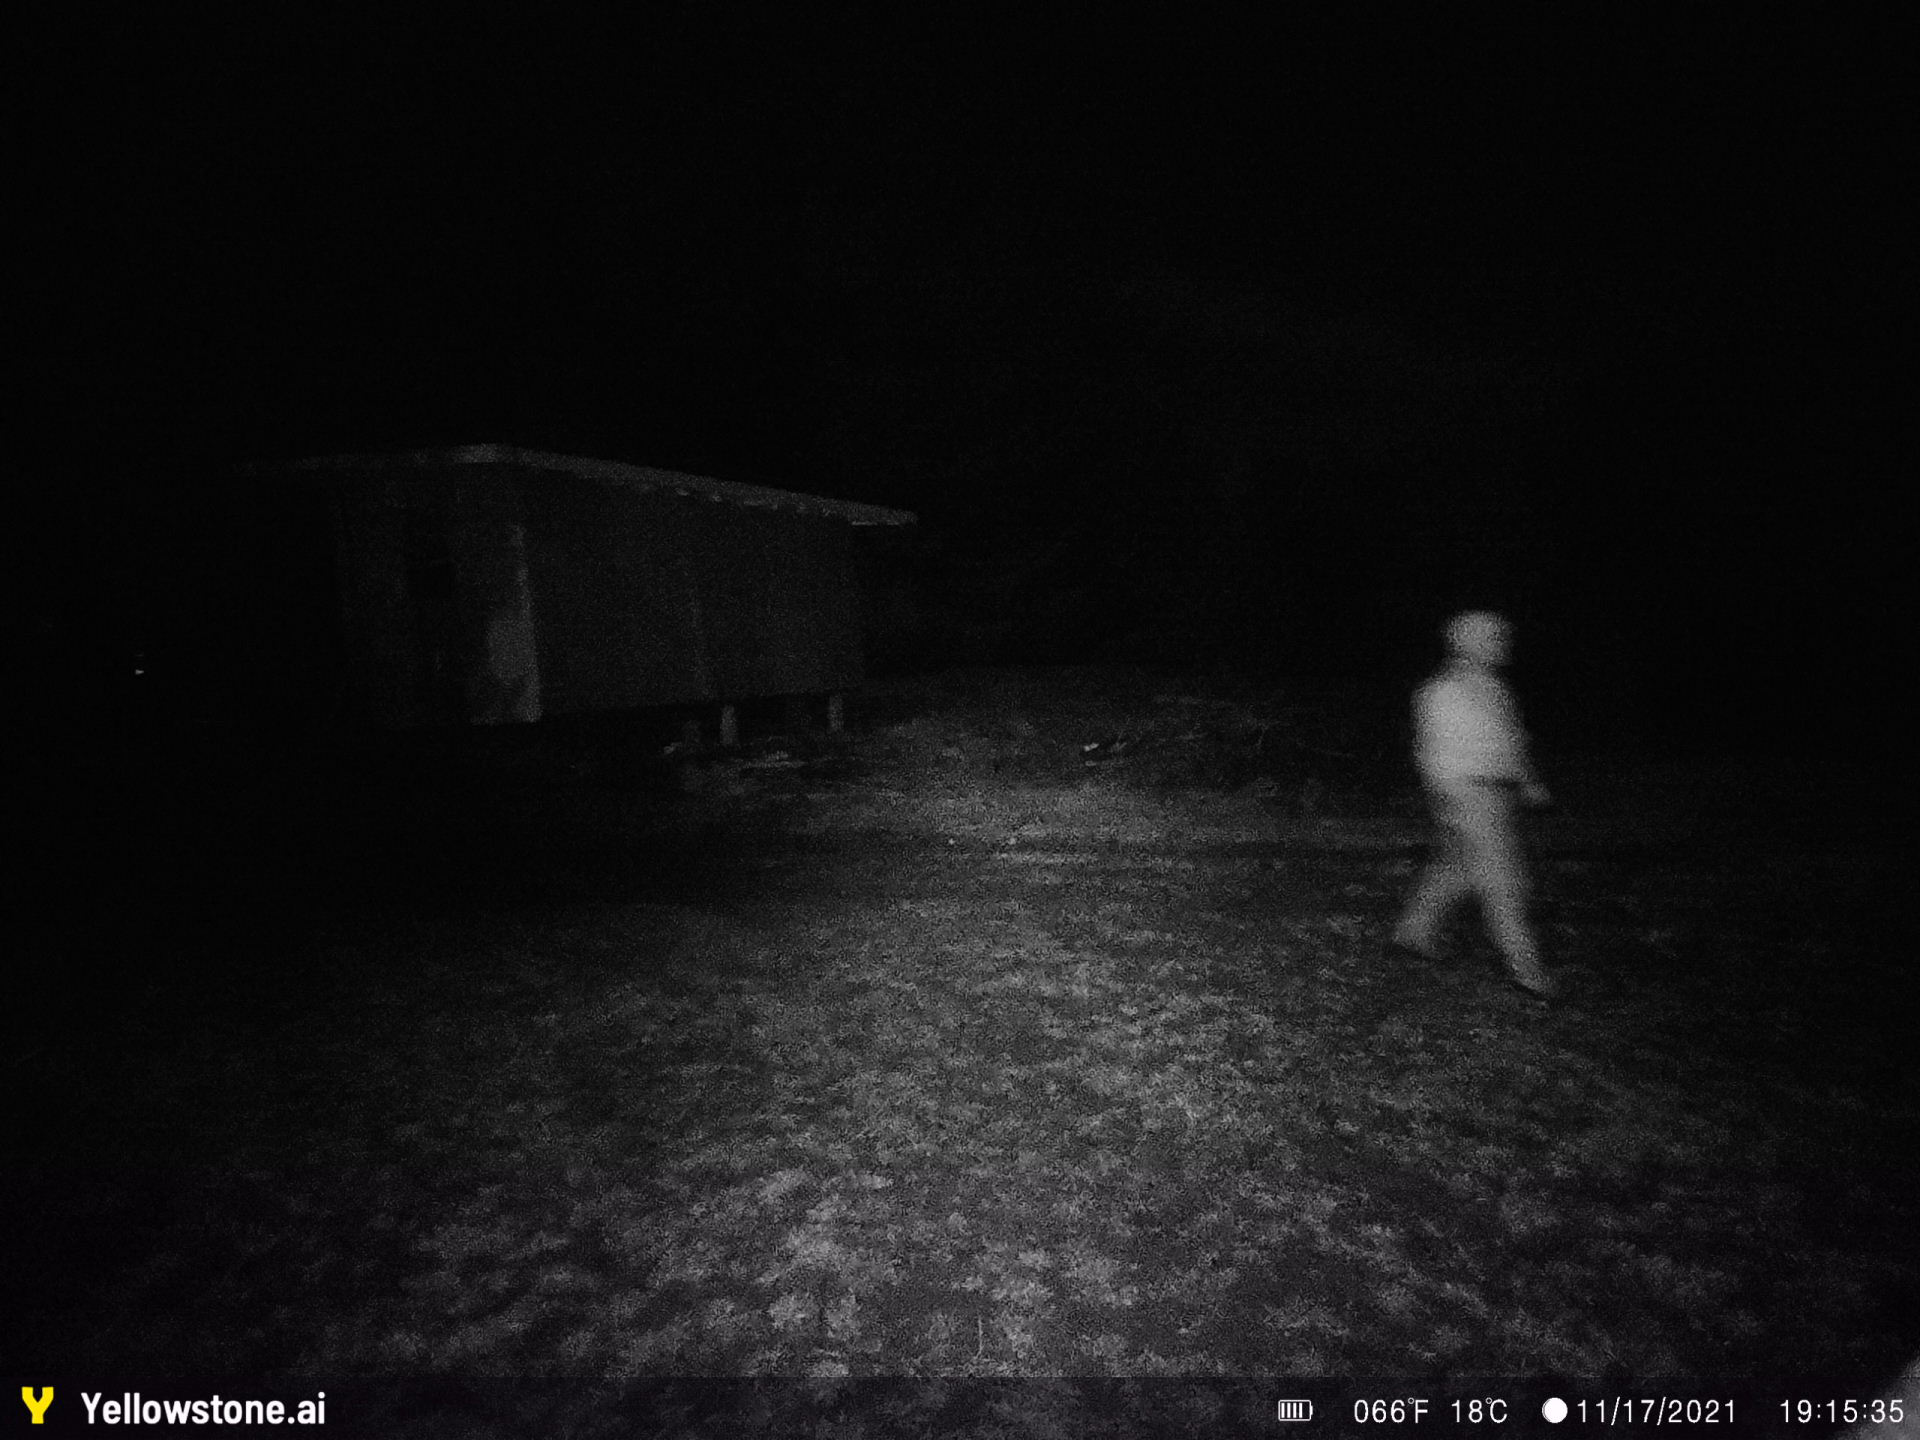

In [8]:
i+=1
path = test[i]['path']
print(i, path)

pred_lbl, conf_idx, confs = inf.predict(path)
pred_conf = round(confs[conf_idx].item(), 2)
for v,c in zip(cats,confs):
    print(v, ":", round(c.item(), 2))
    
load_image(path)

How does it miss THAT, but gets a blurry, partial deer at night?? There's something interesting going on.

Let's see what happens when we crop out everything except the dear itself.

In [9]:
im = load_image(path)
w,h = im.size

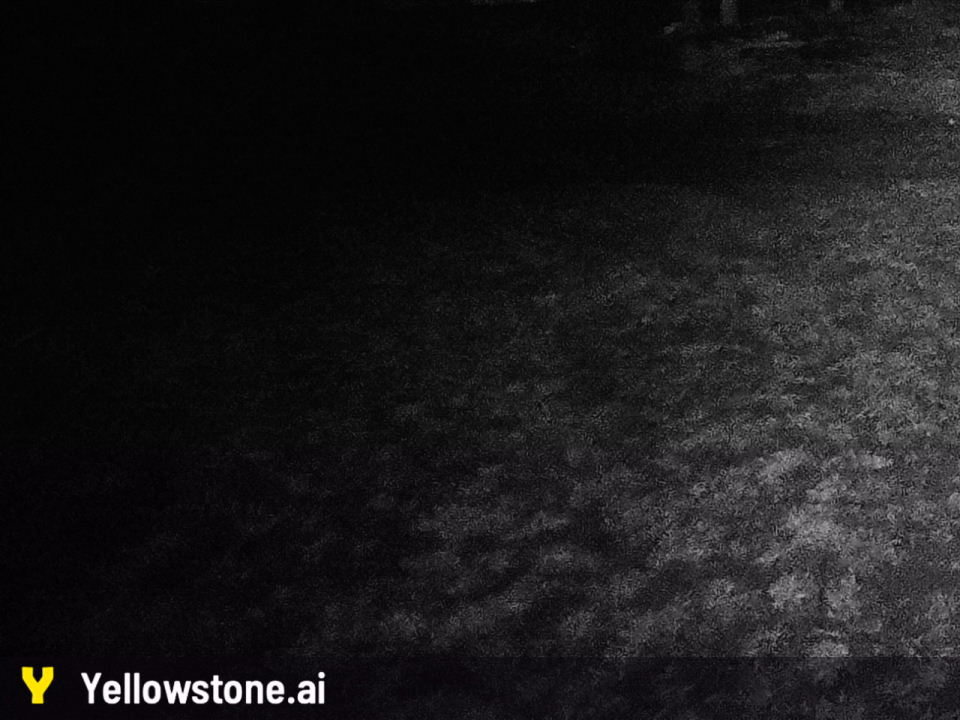

In [10]:
im.crop((0, h/2, w/2, h))

Almost... Just slightly to the right...

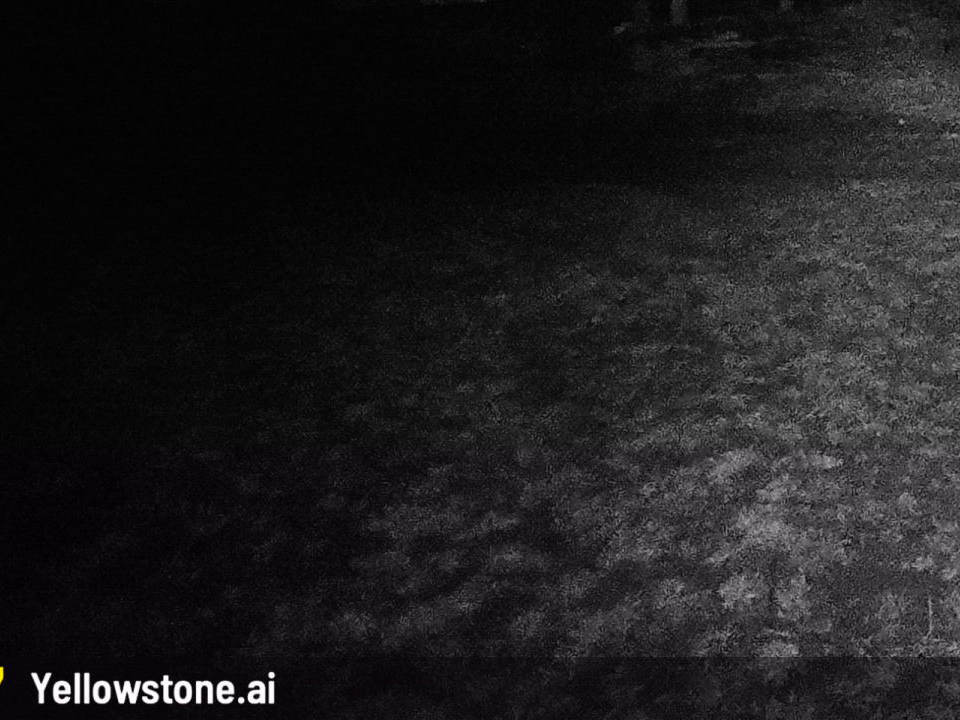

In [11]:
im.crop((0+50, h/2, w/2+50, h))

At'll'do. Let's save it and see what the prediction is for this cropped image.

In [12]:
cropped_fn = "cropped.jpg"
im.crop((0+50, h/2, w/2+50, h)).save(cropped_fn)
inf.predict(cropped_fn)

('american black bear',
 tensor(0),
 tensor([0.6685, 0.2308, 0.0041, 0.0727, 0.0225, 0.0013]))

Bingo – deer at 97%. Out of curiosity, what is the prediction for the roughly-cropped image (missing the deer's face/antlers).

In [13]:
im.crop((0, h/2, w/2, h)).save(cropped_fn)
inf.predict(cropped_fn)

('american black bear',
 tensor(0),
 tensor([0.7856, 0.1360, 0.0099, 0.0403, 0.0147, 0.0135]))

Interesting – you can see from the probabilities that it's split on three of them (black bear "wins" by less than a percentage point).

Let's focus just on preds for images with deer. We'll filter `test` to only include my trailcam images of deer, then we'll make a prediction for each image, then count the predictions by class to get a sense of the overall accuracy.

In [14]:
deer = test.filter(lambda t: 'deer' in t['cats'])
deer_preds = deer.map(lambda d: inf.predict(d['path']))

In [15]:
Counter(deer_preds.map(lambda p: p[0])).most_common()

[('mule deer', 30),
 ('vehicle', 19),
 ('empty', 8),
 ('cougar', 5),
 ('american black bear', 1)]

That's 30/63 = 48% accuracy, which is FAR LESS than what we were lead to believe when training the model! The reason for that is that camera trap models are never as accurate for "out of sample" data (meaning pictures from new locations). The models are only good at classifying images from locations its seen before.

Let's take a look at some predictions to see if we can find a theme.

In [16]:
i=-1

i=3 | mule deer 1.0 | /home/rory/data/trailcam/1637240713_SYFW0806.jpg


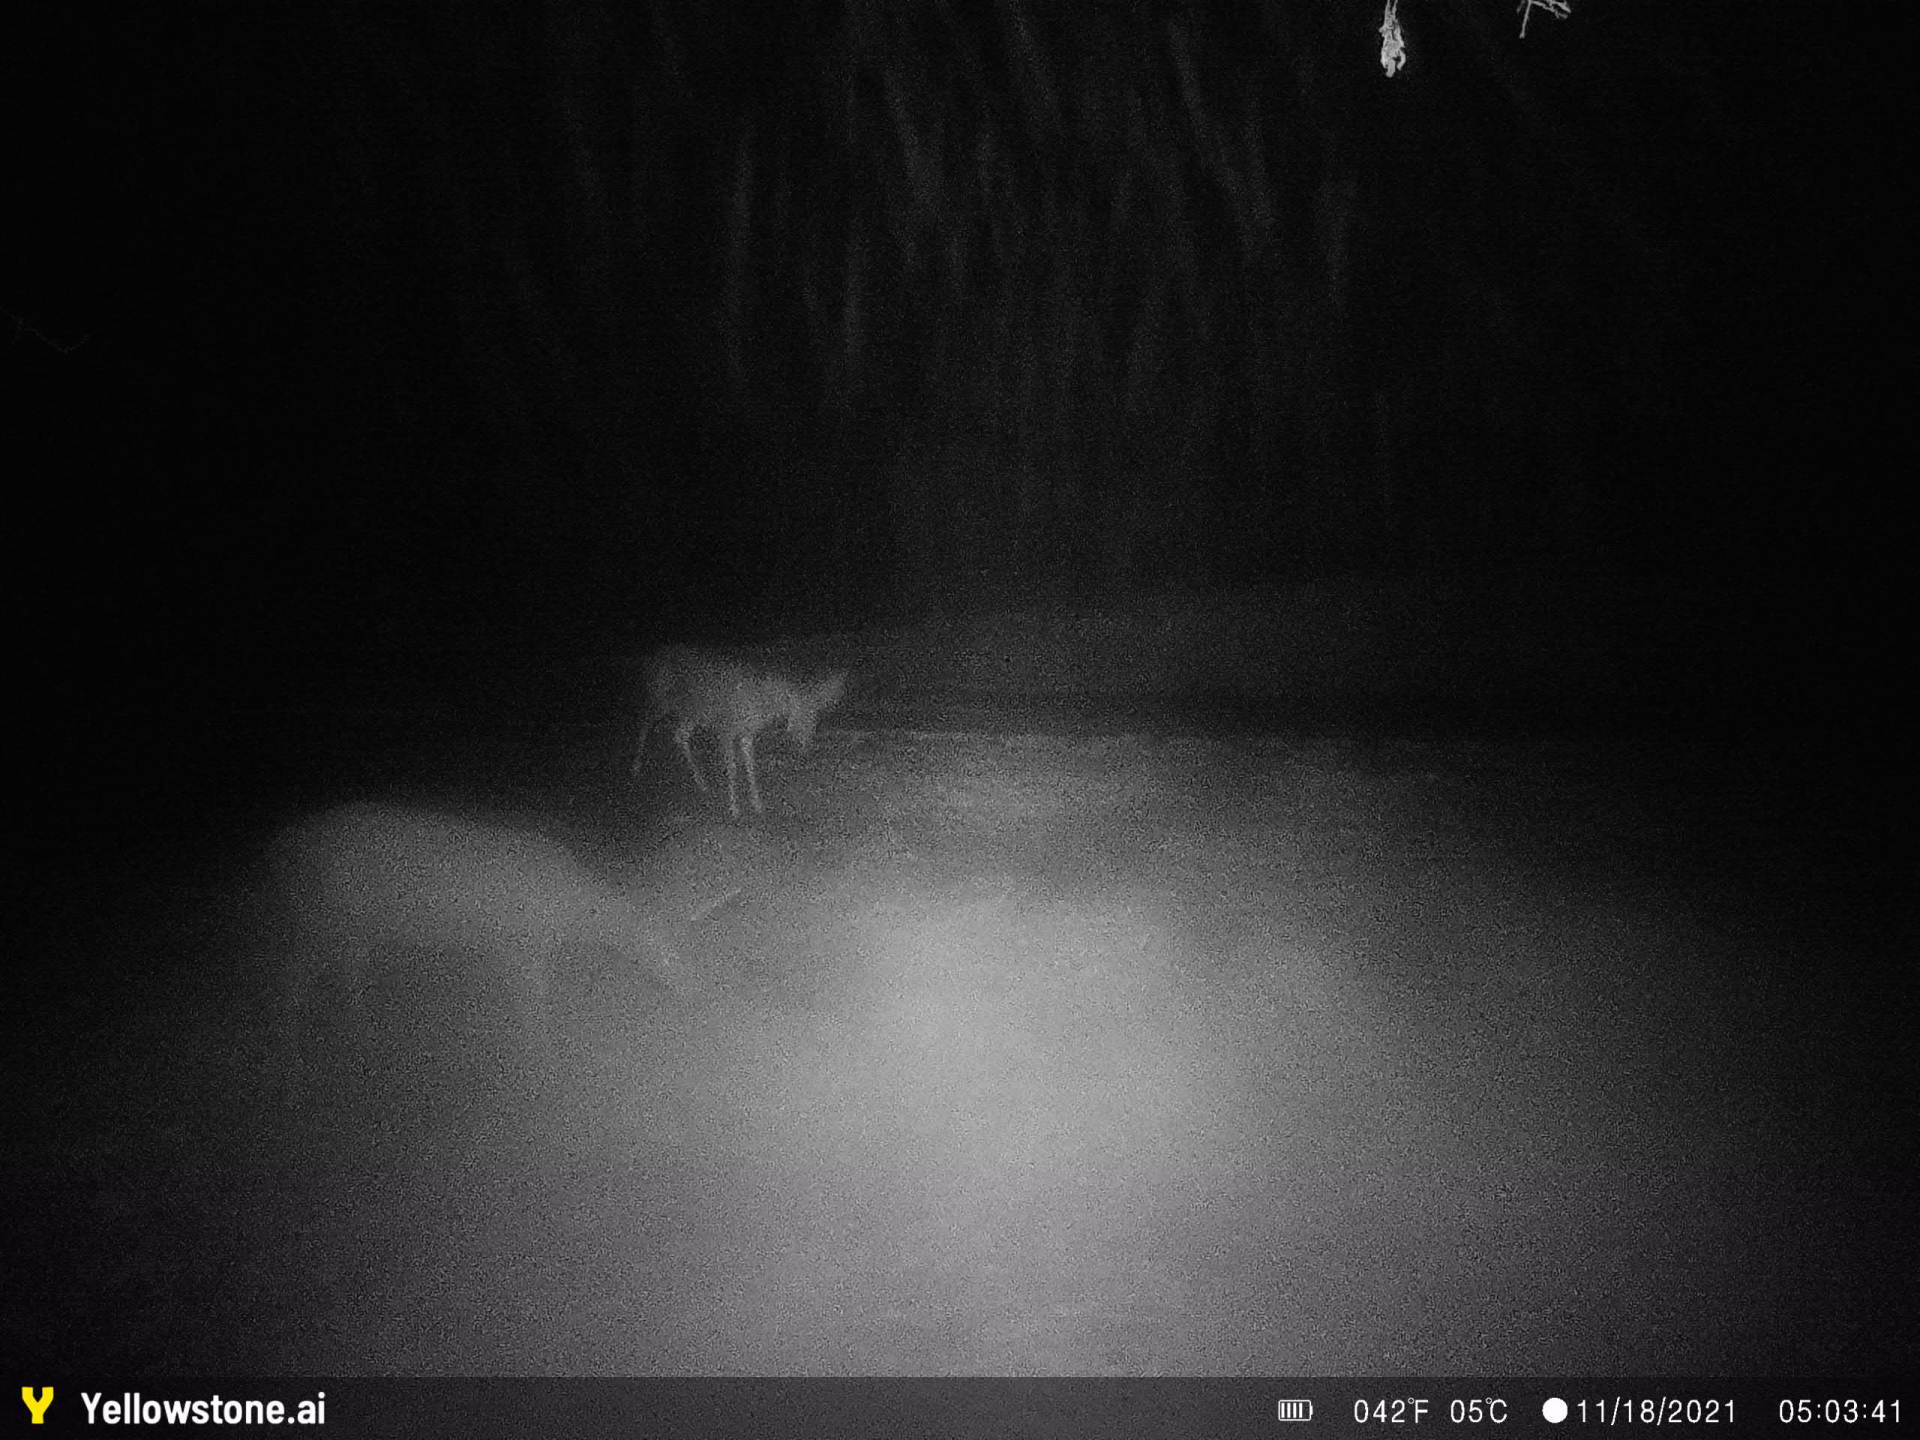

In [20]:
i+=1
path = deer[i]['path']
pred_lbl, conf_idx, confs = inf.predict(path)
pred_conf = round(confs[conf_idx].item(), 2)
print(f"i={i} | {pred_lbl} {pred_conf} | {path}")
load_image(path)

After looking through the images, here's what stood out to me:
- The model was getting the images of deer at night mostly correct. When it was wrong, it was wrong randomly.
- The model was failing to identify images of deer during the day and labeled most of them as "vehicle".
- The images are from a location where both a train track and a dirt road are visible during only the day.

Based on those three points, I believe that the model is seeing the tracks and the road and assuming that the image has a vehicle in it. This is a perfect example of what we mean by a model performing poorly on "out of sample" images.

Along with that issue, I noticed two other interesting things. First, the deer in the leaf-litter are actually quite well hidden! Second, the night images have less landscape detail and more animal detail. These factors probably further contribute to the black-and-white images outperforming.

# Next step: pre-process images with bounding boxes

If I were to improve my predictions further, I'd do the following:
- Train a bounding box model to identify 'vehicle', 'person', and 'animal' to crop each image to specific regions of interest.
- Retrain this classification model for animal labels only using the cropped bounding boxes instead of the entire images.

The above approach seems to have worked well for others and is how the camera trap team at Microsoft built their MegaDetection bounding box model for trailcams. It's actually a common approach to pre-processing image data in many machine learning pipelines.

This notebook by the Microsoft camera trap team shows how to use their pretrained MegaDetection model on any images uploaded to Google Drive: [Megadetector_Colab_test.ipynb](https://colab.research.google.com/github/microsoft/CameraTraps/blob/master/detection/megadetector_colab.ipynb#scrollTo=s5uwmpmaTZMX) (link goes to a Colab notebook).